In [1]:
import os
import maboss
import pandas as pd
from tqdm import tqdm

In [2]:
# Setup the name of the files
model_name =  'Autophagy_and_apoptosis'
project_name = 'Autophagy_and_apoptosis'

In [3]:

######################################################################
##              Load and parameterize model                         ##
######################################################################
## Setup model folder
model_folder = "../model/" + model_name

## Set up the required files
bnd_file = model_folder + ".bnd"
cfg_file = model_folder + ".bnd.cfg"

## Load MaBoSS model
model = maboss.load(bnd_file, cfg_file)

## Setting up the parameters
model.update_parameters(sample_count = 1000,
                        max_time = 50,
                        time_tick = 1,
                        thread_count = 15)

## Put all inputs at 0 and set SMAD2, SMAD3, SMAD4 at 1
for i in model.network.names:
    model.network.set_istate(i,[1,0])

## Proliferation condition
model.network.set_istate('O_stress',[1,0])
model.network.set_istate('Growth_factor',[0,1])
model.network.set_istate('Insuline',[0.5,0.5])
model.network.set_istate('Glucose_starv',[1,0])
model.network.set_istate('AA_Starvation',[1,0])
model.network.set_istate('TNF_R_or_DR',[0.5,0.5])

In [4]:
# Perform simulation
static_node = ["O_stress","Growth_factor","Insuline",'Glucose_starv',"AA_Starvation","TNF_R_or_DR","Lysosome_prod",'Proliferation','Atphgo_form','Atphgo_mat',"Autop_digestion"
               "Apoptosis"]
target_nodes = list(set(model.network.names)-set(static_node))

In [5]:
# Perform baseline simulation
result = model.run()
df_res = result.get_nodes_probtraj().copy()
df_res['mutation'] = 'wildtype'
df_res['timepoint'] = df_res.index
df_res['mutation_type'] = 'None'

# Store all mutation results
mutation_results = {}
mutation_results['wildtype'] = df_res

# Perturb each target node to OFF one at a time
for i in tqdm(target_nodes):
    #print(f"Mutating {i} to OFF...")
    
    # Create a copy of the model and mutate
    model_mut = maboss.copy_and_mutate(model, [i], "OFF")
    
    # Run simulation
    res_mut = model_mut.run()
    
    # Get probability trajectory
    df_res_mut = res_mut.get_nodes_probtraj().copy()
    df_res_mut['mutation'] = i + '_OFF'
    df_res_mut['timepoint'] = df_res_mut.index
    df_res_mut['mutation_type'] = 'OFF'

    # Store results with mutation name as key
    mutation_results[i + '_OFF'] = df_res_mut

# Perturb each target node to ON one at a time
for i in tqdm(target_nodes):
    #print(f"Mutating {i} to ON...")
    
    # Create a copy of the model and mutate
    model_mut = maboss.copy_and_mutate(model, [i], "ON")
    
    # Run simulation
    res_mut = model_mut.run()
    
    # Get probability trajectory
    df_res_mut = res_mut.get_nodes_probtraj().copy()
    df_res_mut['mutation'] = i + '_ON'
    df_res_mut['timepoint'] = df_res_mut.index
    df_res_mut['mutation_type'] = 'ON'

    # Store results with mutation name as key
    mutation_results[i + '_ON'] = df_res_mut

# Each mutation becomes a separate column or can be accessed individually
print(f"Completed {len(target_nodes)} mutations")
#print(f"Available results: {list(mutation_results.keys())}")

100%|██████████| 109/109 [01:22<00:00,  1.32it/s]

Completed 109 mutations


In [6]:
df_all_mutations = pd.concat(mutation_results.values(), ignore_index=True)
# Filter to only include timepoints from 0 to 40
df_all_mutations = df_all_mutations[(df_all_mutations['timepoint'] >= 0) & (df_all_mutations['timepoint'] <= 40)]
df_all_mutations

,Apoptosis,Proliferation,O_stress,Growth_factor,TNF_R_or_DR,AA_Starvation,NFE2L2,KEAP1,GSK3A,NQO1,STK11,AHSA1,ATM,Ulk_C,p21,TP53_nuc,FOXO,MTOR,ATG13,RB1CC1,TP53_cyto,ULK1,PRKA,EIF2AK3,RPTOR,TSC2,AMBRA1,MDM2,BCL2_BECN1_C,BECN1,AKT1,PIK3CA,RRAGA,ATG14,PIK3C3,RAB7A,UVRAG,PI3P,MAP1LC3A_II,ATG3,RPS6KB1,IRS1,PTEN,Atphgo_form,Atphgo_mat,RHEB,FKBP8,PPP2R,PDGFRA,EIF4E,RHOA,ROCK,NEDD4,EIF4EBP1,TRAF6,TFEB,MYC,MON1A,Atg16L_Atg5_Atg12,NFkappaB,IKBKB,NFKBIA,Autop_digestion,pRB,Cell_cycle,BAX,BBC3,MOMP,Cyt_C,Caspase9_APAF1_C,Caspase_3_6_7_C,BCL2L11,MAPK8,YWHAB,PINK1,PARK2,CASP8,DAPK1,MAP3K,PRKD1,MAP2K1,Lysosome_prod,BCL2,H2O2,MTOR_C2,BID,FLIP,RAS,RAF,SOS,GRB2,GAB,EGFR,Insuline,JIP,Kinesin_1,Tubulin,WIPI_1,SP1,mRNA_BBC3,ER_stress,Glucose_starv,Ca_cyto,CAMKKB,IRE1,IP3R,IP3R_VDAC,Mito_overcharge,mRNA_CHOP,CHOP,mRNA_BCL2,mRNA_BCL2L11,CHOP_sustained,ROMO1,mRNA_ROMO1,mRNA_ATF4,ATF4,mRNA_SP1,SP1_sustained,mutation,timepoint,mutation_type
0,0.012533,0.030059,0.0,0.999967,0.517016,0.0,0.367614,0.0,0.368265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009849,0.370537,0.362971,0.0,0.0,0.0,0.0,0.114645,0.0,0.0,0.009311,0.0,0.0,0.040355,0.182478,0.366820,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000319,0.180556,0.020895,0.0,0.0,0.372741,0.259438,0.0,0.362825,0.268600,0.318276,0.087937,0.047682,0.357584,0.0,0.373564,0.000000,0.0,0.0,0.271249,0.0,0.362326,0.0,0.0,0.355242,0.011094,0.0,0.001957,0.000446,0.000315,0.044191,0.0,0.000000,0.008660,0.000097,0.000000,0.134917,0.000000,0.000000,0.000000,0.000029,0.096649,0.095904,0.0,0.0,0.042125,0.184012,0.002062,0.000505,0.021382,0.108059,0.028095,0.367970,0.504978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.367433,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,wildtype,0.0,None
1,0.072816,0.147072,0.0,1.000043,0.517029,0.0,0.787837,0.0,0.657929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.100591,0.728806,0.785268,0.0,0.0,0.0,0.0,0.439987,0.0,0.0,0.112304,0.0,0.0,0.294303,0.588196,0.768319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028320,0.383096,0.147575,0.0,0.0,0.760640,0.331678,0.0,0.731564,0.362245,0.456311,0.314719,0.298496,0.722657,0.0,0.738295,0.000000,0.0,0.0,0.334308,0.0,0.760071,0.0,0.0,0.752259,0.044737,0.0,0.016827,0.006350,0.002616,0.135207,0.0,0.000000,0.106565,0.007888,0.001357,0.172629,0.000191,0.000917,0.000157,0.007891,0.422387,0.417155,0.0,0.0,0.127425,0.394746,0.069448,0.024468,0.184224,0.437331,0.190059,0.774408,0.505029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.768534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,wildtype,1.0,None
2,0.111097,0.216563,0.0,1.000038,0.517007,0.0,0.927952,0.0,0.569170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.315196,0.758916,0.931059,0.0,0.0,0.0,0.0,0.712145,0.0,0.0,0.310081,0.0,0.0,0.526710,0.703367,0.928848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.146343,0.434447,0.236668,0.0,0.0,0.907126,0.207731,0.0,0.764393,0.279762,0.375300,0.377367,0.535671,0.758965,0.0,0.762126,0.001230,0.0,0.0,0.208002,0.0,0.918050,0.0,0.0,0.899427,0.052034,0.0,0.031850,0.019177,0.010897,0.139882,0.0,0.000000,0.309045,0.016908,0.009194,0.107824,0.006621,0.016627,0.001730,0.047035,0.634696,0.700829,0.0,0.0,0.131614,0.467915,0.236391,0.109090,0.439501,0.707273,0.454575,0.919570,0.505020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.913305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,wildtype,2.0,None
3,0.117038,0.246162,0.0,0.999988,0.516972,0.0,0.972224,0.0,0.393937,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.558790,0.634895,0.977860,0.0,0.0,0.0,0.0,0.875457,0.0,0.0,0.496058,0.0,0.0,0.650532,0.735283,0.975952,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.338061,0.400865,0.254551,0.0,0.0,0.962400,0.112149,0.0,0.619150,0.297845,0.312396,0.352183,0.648605,0.614481,0.0,0.620783,0.013643,0.0,0.0,0.101986,0.0,0.972658,0.0,0.0,0.958799,0.032516,0.0,0.039888,0.030622,0.018625,0.109193,0.0,0.005741,0.495653,0.028453,0.019892,0.049504,0.029931,0.060818,0.013883,0.138917,0.661701,0.857722,0.0,0.0,0.091632,0.499243,0.469617,0.277415,0.676782,0.857621,0.670247,0.972579,0.504973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.966285,0.0,0.0,0.0,0.0,

In [7]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Initialize PCA (let's reduce to 2 principal components for this example)
pca = PCA(n_components=10)

# Fit and transform the data
df_pca = df_all_mutations.drop(['mutation','timepoint','mutation_type'], axis = 1) 
pca_result = pca.fit_transform(df_pca)

# Convert the result back to a DataFrame for easier interpretation
pca_df = pd.DataFrame(data=pca_result, index=df_pca.index)

# number pca column
number_list = list(range(pca_result.shape[1]))
str_list = [str(i+1) for i in number_list]
pca_df.columns = ['pc' + s for s in str_list]

# Add model_id and timepoint backinto dataframe
pca_df['mutation'] = df_all_mutations['mutation']
pca_df['timepoint'] = df_all_mutations['timepoint'].astype('float')
pca_df['mutation_type'] = df_all_mutations['mutation_type']

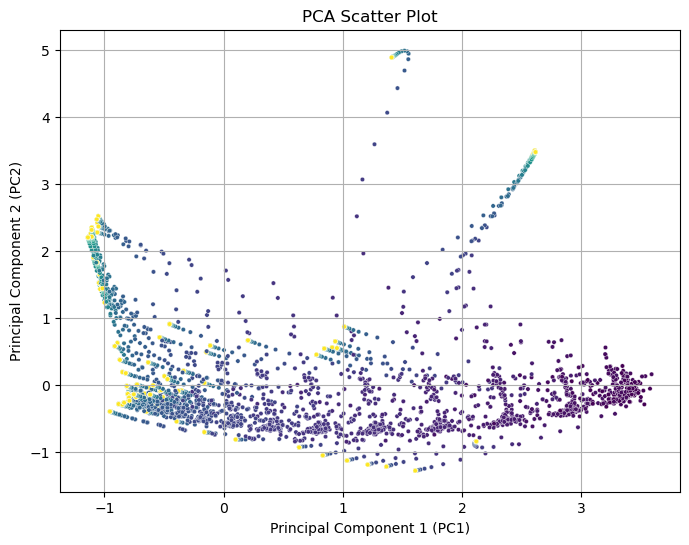

In [9]:
plt.figure(figsize=(8, 6))

# Scatter plot using Seaborn
sns.scatterplot(data = pca_df, x='pc1', y='pc2', s=10, hue = 'timepoint', palette='viridis', legend=None)

# Add title and labels
plt.title('PCA Scatter Plot')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')

# Display the plot
plt.grid(True)
plt.show()

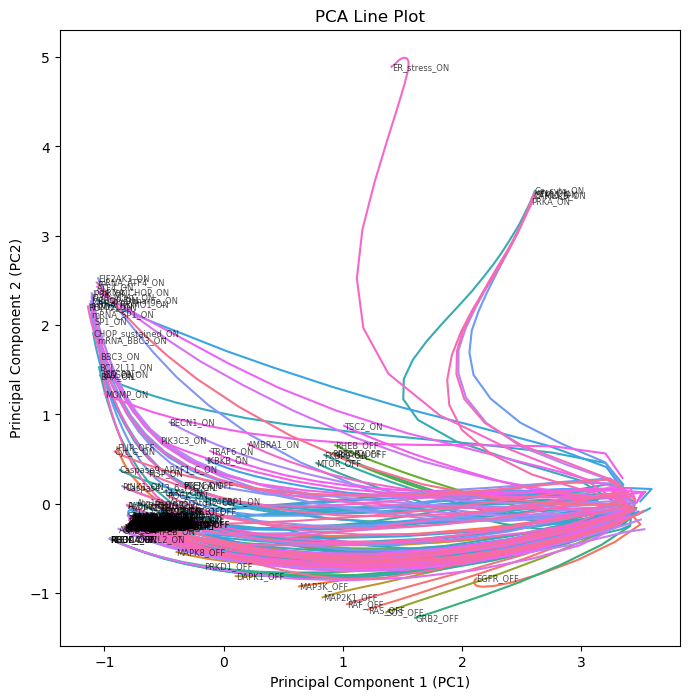

In [20]:
plt.figure(figsize=(8, 8))

# Line plot using Seaborn
sns.lineplot(data = pca_df, x='pc1', y='pc2',
             units = 'mutation', estimator=None,
             hue = 'mutation', legend=None, sort=False)

# Add title and labels
plt.title('PCA Line Plot')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')

# Add labels at the end of each line
for mutation in pca_df['mutation'].unique():
    mutation_data = pca_df[pca_df['mutation'] == mutation]
    last_point = mutation_data.iloc[-1]
    plt.text(last_point['pc1'], last_point['pc2'], mutation, fontsize=6, ha='left', va='center', alpha=0.7)

# Display the plot
#plt.grid(True)
plt.show()

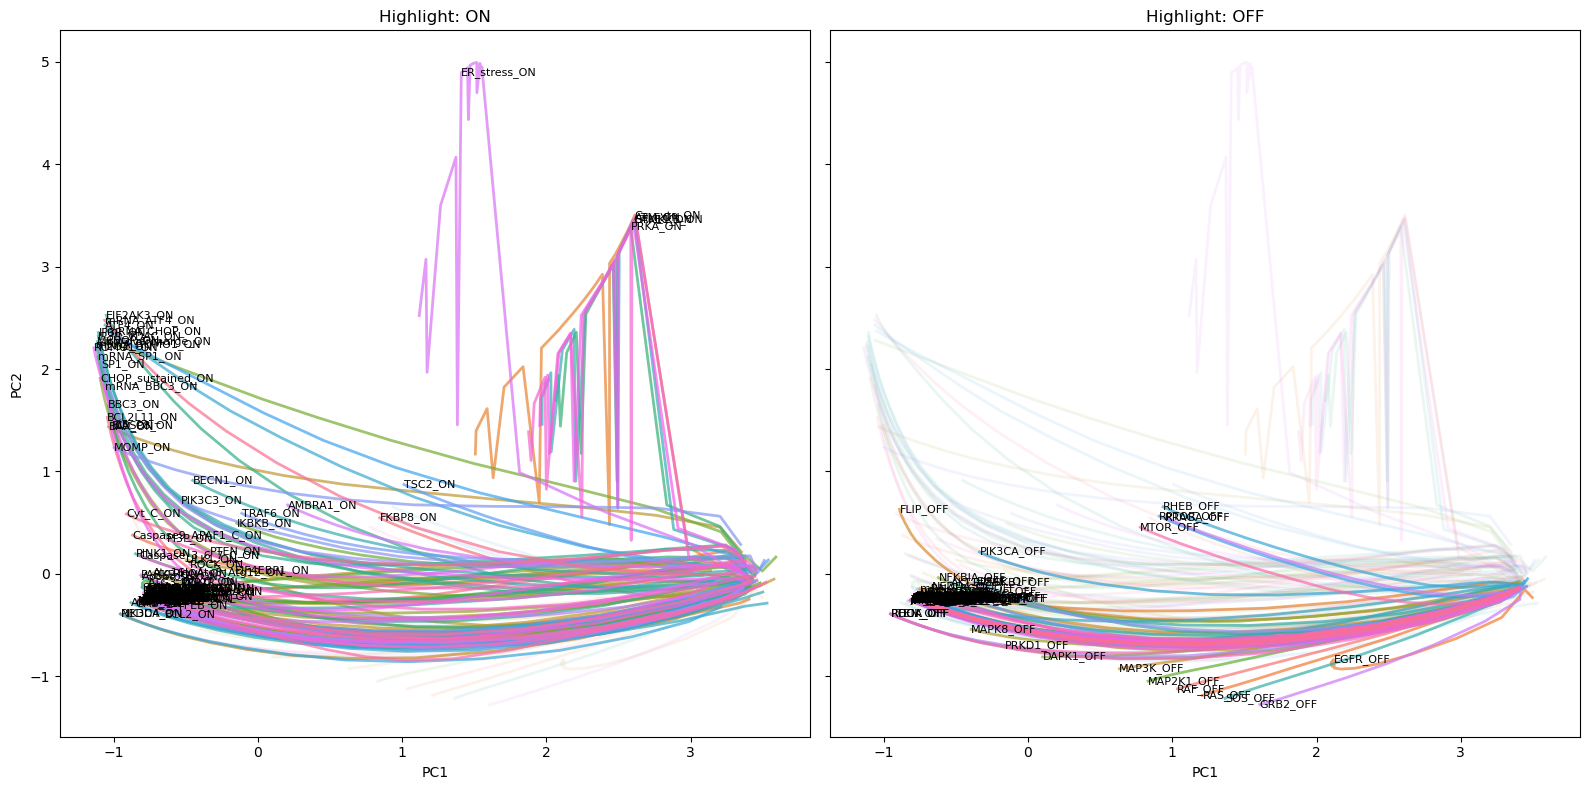

In [21]:
## Calculate the mean position
line_cluster = pca_df.groupby(['timepoint'])[['pc1','pc2']].mean()

## Plot with Seaborn
import seaborn as sns
from matplotlib.pyplot import rc_context

highlight_types = ['ON', 'OFF']
with rc_context({"figure.figsize": (16, 8)}):
    fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
    for idx, highlight in enumerate(highlight_types):
        ax = axes[idx]
        # Highlighted data
        highlight_df = pca_df[pca_df['mutation_type'] == highlight]
        # Other data
        other_df = pca_df[pca_df['mutation_type'] != highlight]
        # Plot other data in grey, low alpha
        if not other_df.empty:
            sns.lineplot(data=other_df, x='pc1', y='pc2', hue='mutation', units='mutation', estimator=None, lw=2, alpha=0.1, legend=False, color='grey', ax=ax)
        # Plot highlighted data in color
        if not highlight_df.empty:
            sns.lineplot(data=highlight_df, x='pc1', y='pc2', hue='mutation', units='mutation', estimator=None, lw=2, alpha=0.7, legend=False, ax=ax)
        ax.set_title(f"Highlight: {highlight}")
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        # Add labels at the end of each line for highlighted mutations
        for mutation in highlight_df['mutation'].unique():
            mutation_data = highlight_df[highlight_df['mutation'] == mutation]
            last_point = mutation_data.iloc[-1]
            ax.text(last_point['pc1'], last_point['pc2'], mutation, fontsize=8, ha='left', va='center')
    plt.tight_layout()
    plt.show()

In [ ]:
import sys
sys.path.append('../')
from maboss_visualize import *

In [ ]:
# Subset the MTOR_OFF mutation
test_visualization = df_all_mutations[df_all_mutations['mutation']=='MTOR_OFF'].copy()
test_visualization = test_visualization.drop(['mutation','timepoint','mutation_type'], axis = 1)
test_visualization = test_visualization.reset_index(drop=True)

# Setup the name of the files
model_files = "/home/spankaew/Git/autophagy/model/Autophagy_and_apoptosis"

# Setup the model name and the network path
network_path = model_files + '.xgmml'

# Load the network into the maboss_visualizer tool
network = Net_visualizer()
network.load_network_xgmml(network_path)

network.load_timeseries(test_visualization)
network.create_networkactivity_animation(number_of_frames=25,
                                         frame_duration=75, 
                                         file_name='Autophagy_proliferation_MTOR_off', 
                                         figure_size = (20,12))

Network loaded : /home/spankaew/Git/autophagy/model/Autophagy_and_apoptosis.xgmml
Generating frames for the GIF...


100%|██████████| 25/25 [00:40<00:00,  1.62s/it]


GIF animation saved at Autophagy_proliferation_MTOR_off.gif


In [23]:
# Subset the MTOR_OFF mutation
test_visualization = df_all_mutations[df_all_mutations['mutation']=='EGFR_OFF'].copy()
test_visualization = test_visualization.drop(['mutation','timepoint','mutation_type'], axis = 1)
test_visualization = test_visualization.reset_index(drop=True)

# Setup the name of the files
model_files = "/home/spankaew/Git/autophagy/model/Autophagy_and_apoptosis"

# Setup the model name and the network path
network_path = model_files + '.xgmml'

# Load the network into the maboss_visualizer tool
network = Net_visualizer()
network.load_network_xgmml(network_path)

network.load_timeseries(test_visualization)
network.create_networkactivity_animation(number_of_frames=25,
                                         frame_duration=75, 
                                         file_name='Autophagy_proliferation_EGFR_OFF', 
                                         figure_size = (20,12))

Network loaded : /home/spankaew/Git/autophagy/model/Autophagy_and_apoptosis.xgmml
Generating frames for the GIF...


100%|██████████| 25/25 [00:39<00:00,  1.57s/it]


GIF animation saved at Autophagy_proliferation_EGFR_OFF.gif


In [22]:
# Subset the MTOR_OFF mutation
test_visualization = df_all_mutations[df_all_mutations['mutation']=='ER_stress_ON'].copy()
test_visualization = test_visualization.drop(['mutation','timepoint','mutation_type'], axis = 1)
test_visualization = test_visualization.reset_index(drop=True)

# Setup the name of the files
model_files = "/home/spankaew/Git/autophagy/model/Autophagy_and_apoptosis"

# Setup the model name and the network path
network_path = model_files + '.xgmml'

# Load the network into the maboss_visualizer tool
network = Net_visualizer()
network.load_network_xgmml(network_path)

network.load_timeseries(test_visualization)
network.create_networkactivity_animation(number_of_frames=25,
                                         frame_duration=75, 
                                         file_name='Autophagy_proliferation_ER_stress_ON', 
                                         figure_size = (20,12))

Network loaded : /home/spankaew/Git/autophagy/model/Autophagy_and_apoptosis.xgmml
Generating frames for the GIF...


100%|██████████| 25/25 [00:44<00:00,  1.78s/it]


GIF animation saved at Autophagy_proliferation_ER_stress_ON.gif
